In [1]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile, lcl_temp_bolton, lcl_sigma_bolton_simple
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure, \
    get_var_at_plev, get_ds_in_pressure_range
from isca_tools.thesis.lapse_integral_simple import get_temp_2_layer_approx, fitting_2_layer_xr
from isca_tools.thesis.mod_parcel_theory import get_scale_factor_theory_numerical, get_temp_mod_parcel
from isca_tools.utils.decomposition import pca_on_xarray
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.thesis.adiabat_theory2 import get_temp_adiabat_surf, get_temp_adiabat
from isca_tools.thesis.profile_fitting import get_mse_env, get_lnb_lev_ind, get_mse_prof_rms
from isca_tools.utils.ds_slicing import lat_lon_coord_slice
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

from isca_tools.utils.xarray import flatten_to_numpy, unflatten_from_numpy, convert_ds_dtypes
from isca_tools.papers.byrne_2021 import get_quant_ind

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [4]:
from jobs.theory_lapse.cesm.tropics.load_ds_quant import ds_quant, surf_use

### Error in Fitting
Below we see that the coldest days have quite a large error, and often more than the `const_lapse` fitting. We exclude these from the subsequent analysis on breaking down the scaling factor into individual mechanisms.

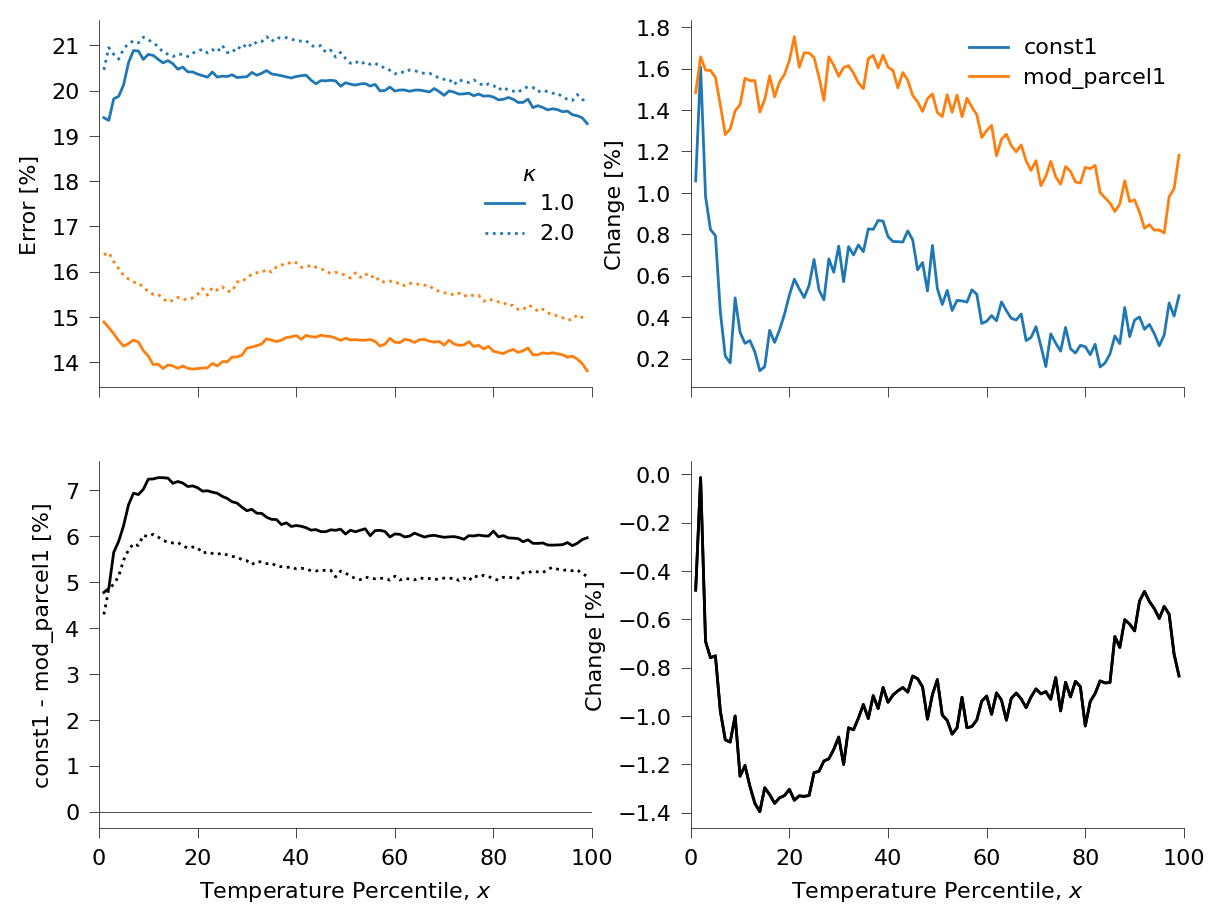

In [6]:
lat_weights = np.cos(np.deg2rad(ds_quant.lat))
percentile_label = 'Temperature Percentile, $x$'

fig, ax = plt.subplots(2, 2, sharex=True)
fig_resize(fig, 7)
var = {}
for j, key in enumerate(['const1', 'mod_parcel1']):
    var[key] = np.abs(
        ds_quant[f'{key}_error'].sum(dim='layer') / ds_quant[f'{key}_integral'].sum(dim='layer') * 100)
    for i in range(ds_quant.co2.size):
        ax[0, 0].plot(ds_quant.quant,
                      np.average(var[key].isel(co2=i).quantile(0.5, dim='sample'), axis=1, weights=lat_weights),
                      linestyle=':' if i == 1 else None, color=f"C{j}",
                      label=f"{ds_quant.co2.values[i]:.1f}" if j == 0 else None)
    ax[0, 1].plot(ds_quant.quant, np.average(var[key].isel(co2=1).quantile(0.5, dim='sample') -
                                             var[key].isel(co2=0).quantile(0.5, dim='sample'), axis=1,
                                             weights=lat_weights),
                  color=f"C{j}", label=key)
var = var['const1'] - var['mod_parcel1']
for i in range(ds_quant.co2.size):
    ax[1, 0].plot(ds_quant.quant,
                  np.average(var.isel(co2=i).quantile(0.5, dim='sample'), axis=1, weights=lat_weights),
                  linestyle=':' if i == 1 else None, color=f"k")
    ax[1, 1].plot(ds_quant.quant, np.average(var.isel(co2=1).quantile(0.5, dim='sample') -
                                             var.isel(co2=0).quantile(0.5, dim='sample'), axis=1,
                                             weights=lat_weights), color=f"k")
update_linewidth(fig)
ax[0, 0].set_ylabel('Error [%]')
ax[0, 0].legend(title='$\kappa$')
ax[0, 1].set_ylabel('Change [%]')
ax[0, 1].legend()
ax[1, 0].set_ylabel('const1 - mod_parcel1 [%]')
ax[1, 0].axhline(0, lw=ax_linewidth, color='k')
ax[1, 1].set_ylabel('Change [%]')
# fig.suptitle(f"{region.capitalize()} | {season.capitalize()} | "
#              f"$p_{'{FT}'} = {p_ft / 100:.0f}$hPa", y=0.93)
ax[0, 0].set_xlim(0, 100)
ax[1, 0].set_xlabel(percentile_label)
ax[1, 1].set_xlabel(percentile_label)
update_fontsize(fig)
plt.show()

In [7]:
ds_sf = ds_quant[['TREFHT', 'PREFHT', 'rh_REFHT', 'T_ft_env', 'mod_parcel1_lapse']]
error = {
    key: np.abs(ds_quant[f'{key}1_error'].sum(dim='layer') / ds_quant[f'{key}1_integral'].sum(dim='layer') * 100)
    for key in ['mod_parcel', 'const']}
mask_use = (error['mod_parcel'] < 25) & (error['mod_parcel'] < error['const'])
# mask_use = mask_use * 0 + 1
ds_sf = ds_sf.where(mask_use).mean(dim='sample')
ds_sf['lapse_mod_D'] = ds_sf['mod_parcel1_lapse'].isel(layer=0) / 1000 - lapse_dry
ds_sf['lapse_mod_M'] = ds_sf['mod_parcel1_lapse'].isel(layer=1) / 1000
ds_sf = ds_sf.drop_vars(['mod_parcel1_lapse', 'layer'])
ds_sf = ds_sf.transpose('co2', 'quant', 'lat')
ds_sf = ds_sf.rename({'TREFHT': 'temp_surf', 'PREFHT': 'p_surf', 'rh_REFHT': 'rh_surf', 'T_ft_env': 'temp_ft'})
for key in ['temp_surf', 'p_surf', 'rh_surf', 'lapse_mod_D', 'lapse_mod_M']:
    ds_sf[key + '_ref'] = ds_sf[key].median(dim='quant')
    if 'lapse' in key:
        ds_sf[key + '_ref'] = np.abs(ds_sf[key + '_ref'] * 0)  # for lapse, ref value is 0
    elif key != 'temp_surf':
        # For rh and pressure, keep at colder climate ref
        ds_sf[key + '_ref'] = ds_sf[key + '_ref'] * 0 + ds_sf[key + '_ref'].isel(co2=0)

### Fraction of days used
In the scaling factor computation, we only include days for which the vertical `mod_parcel1` profile is good. We define *good* as having the error less than 25% and having a smaller error than the `const1` method.

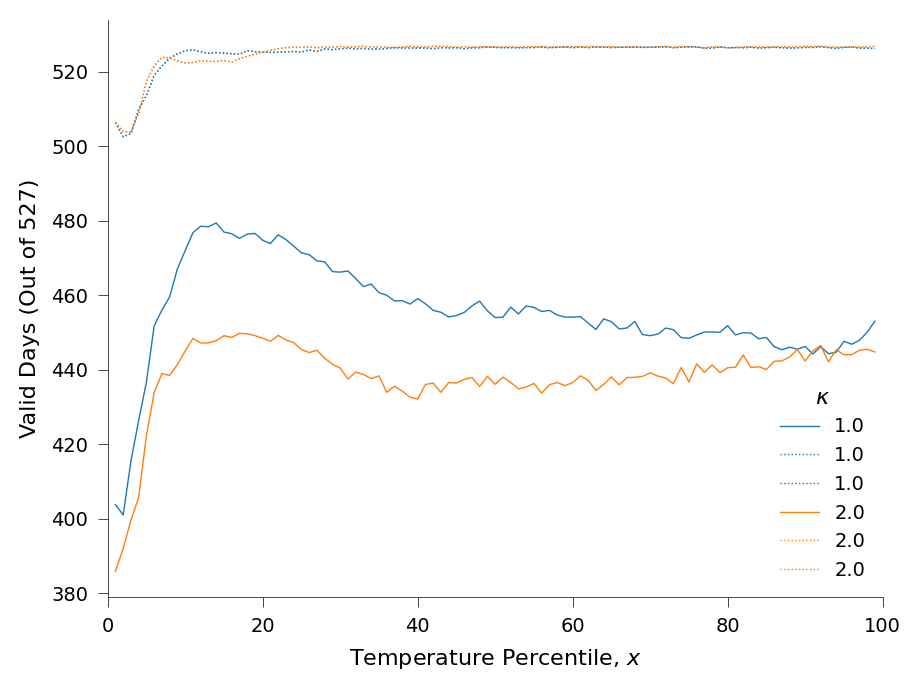

In [8]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
n_days_dry = np.isnan(ds_quant.mod_parcel1_lapse).sum(dim='sample')
for i in range(ds_quant.co2.size):
    ax.plot(ds_quant.quant, np.average(mask_use.sum(dim='sample').isel(co2=i), axis=1, weights=lat_weights),
            label=f"{mask_use.co2.values[i]:.1f}", color=f"C{i}")
    # Below show days which no error possible because LCL too close to p_ft
    ax.plot(ds_quant.quant, ds_quant.sample.size-np.average(n_days_dry.isel(co2=i), axis=1, weights=lat_weights),
            label=f"{mask_use.co2.values[i]:.1f}", color=f"C{i}", linestyle=':')
ax.set_xlabel(percentile_label)
ax.set_ylabel(f"Valid Days (Out of {ds_quant.sample.size:.0f})")
ax.set_xlim(0, 100)
ax.legend(title='$\kappa$')
plt.show()

### Scale Factor Breakdown
Now, we compute the breakdown of the scaling factor into all the different physical mechanisms using a numerical method.

We include a linear and non-linear contribution for each mechanism. These are combined unless `show_non_linear=True`. The linear mechanism is really the best we can hope for once we make all the taylor series approximations.

In [9]:
def apply_scale_factor(ds, p_ft=ds_quant.p_ft):
    """Apply get_scale_factor_theory_numerical to an xarray.Dataset."""

    out_main, out_linear, out_dict = xr.apply_ufunc(
        get_scale_factor_theory_numerical,
        ds["temp_surf_ref"],  # (co2)
        ds["temp_surf"],  # (co2, quant)
        ds["rh_surf_ref"],  # (co2)
        ds["rh_surf"],  # (co2, quant)
        ds["temp_ft"],  # (co2, quant)
        ds["lapse_mod_D"],  # (co2, quant)
        ds["lapse_mod_M"],  # (co2, quant)
        p_ft,  # (co2) or scalar
        ds["p_surf_ref"],  # (co2) or scalar
        ds["p_surf"],  # (co2, quant) or None
        ds["lapse_mod_D_ref"],  # (co2) or None
        ds["lapse_mod_M_ref"],  # (co2) or None
        kwargs=dict(
            temp_surf_lcl_calc=300
        ),
        input_core_dims=[
            ["co2"],  # temp_surf_ref
            ["co2", "quant"],
            ["co2"],
            ["co2", "quant"],
            ["co2", "quant"],
            ["co2", "quant"],
            ["co2", "quant"],
            [],  # p_ft_ref
            ["co2"],  # p_surf_ref
            ["co2", "quant"],
            ["co2"],
            ["co2"],
        ],
        output_core_dims=[
            ["quant"],  # result array
            ["quant"],
            []  # dict-of-arrays (broadcast to co2)
        ],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float, object],
    )

    # Expand the dictionary output entries into proper DataArrays
    dict_ds = {'scale_factor': (ds['temp_surf'].isel(co2=1) - ds['temp_surf'].isel(co2=0)
                                ) / (ds['temp_surf_ref'].isel(co2=1) - ds['temp_surf_ref'].isel(co2=0))}

    # Determine all dict keys from the first element
    dict_single_lat = out_dict.isel(lat=0).item()
    keys = list(dict_single_lat.keys())

    for key in keys:
        # Collect arrays across lat dimension
        stacked = []
        for i in range(out_dict.sizes["lat"]):
            arr = out_dict.isel(lat=i).item()[key]  # (quant,)
            stacked.append(arr)

        da = xr.DataArray(
            np.stack(stacked, axis=0),  # (lat, quant)
            dims=("lat", "quant"),
            coords={"lat": ds.lat, "quant": ds.quant},
        )
        dict_ds[key] = da

    ds_out = xr.Dataset({"scale_factor_sum": out_main, "scale_factor_linear": out_linear, **dict_ds})
    ds_out = ds_out.transpose("lat", "quant")
    return ds_out

In [10]:
style_map = {
    # --- reference change (dashed) ---
    "r_ref_change": ("C0", "--"),
    "p_surf_ref_change": ("C2", "--"),
    "lapse_mod_D_ref_change": ("C1", "--"),
    "lapse_mod_M_ref_change": ("C3", "--"),

    # --- change (solid) ---
    "temp_ft_change": ("C2", "-"),
    "r_change": ("C0", "-"),
    "lapse_mod_D_change": ("C1", "-"),
    "lapse_mod_M_change": ("C3", "-"),
    "p_surf_change": ("C1", "-"),
    "error_av_change": ("C5", "-"),

    # --- anomalies (dotted) ---
    "temp_anom": ("C2", ":"),
    "r_anom": ("C0", ":"),
    "lapse_mod_D_anom": ("C1", ":"),
    "lapse_mod_M_anom": ("C3", ":"),
    "p_surf_anom": ("C1", ":"),

    # nl
    "nl_residual": ("C5", "-."),

    # sf
    "scale_factor": ('k', "-"),
    "scale_factor_linear": ('k', ":"),
    "scale_factor_sum": ('k', "--")
}
for key2 in [k for k in style_map if "nl" not in k and "ref" not in k]:
    style_map['nl_' + key2] = (style_map[key2][0], '-.')

ds_out = apply_scale_factor(ds_sf)

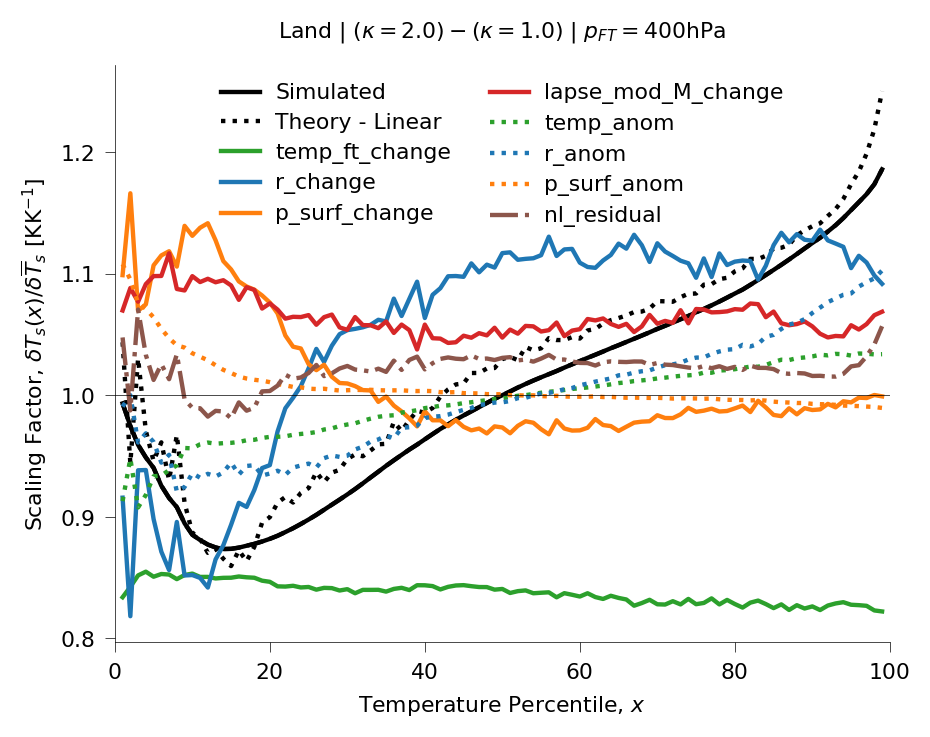

In [14]:
show_non_linear = False

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
fig_resize(fig, 5)
for key in ['', '_sum', '_linear']:
    ax.plot(ds_out.quant, np.average(ds_out[f"scale_factor{key}"], axis=0, weights=lat_weights),
            color=style_map[f"scale_factor{key}"][0], linestyle=style_map[f"scale_factor{key}"][1],
            label={'': 'Simulated', '_linear': 'Theory - Linear', '_sum': None}[key])
for key in ds_out:
    var = ds_out[key]
    if 'scale_factor' in key:
        continue
    elif 'nl' in key:
        # Combine non-linear and linear into single mechanism on plot
        if (not show_non_linear) and ('residual' not in key):
            var = var + ds_out[key.replace('nl_', '')] - 1
            key = key.replace('nl_', '')
    elif not show_non_linear:
        continue
    if np.average(np.abs(var - 1), axis=0, weights=lat_weights).max() < 0.08:
        continue
    ax.plot(ds_out.quant, np.average(var, axis=0, weights=lat_weights), label=key,
            color=style_map[key][0], linestyle=style_map[key][1])
update_linewidth(fig)
ax.legend(ncol=2)
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_xlabel(percentile_label)
ax.set_ylabel("Scaling Factor, $\delta T_s(x)/\delta \overline{T}_s$ [KK$^{-1}$]")
ax.set_title(
    f"{surf_use.capitalize()} | $(\kappa = {ds_sf.co2.values[1]}) - (\kappa = {ds_sf.co2.values[0]})$ | "
    f"$p_{'{FT}'} = {ds_quant.p_ft / 100:.0f}$hPa", y=1.02)
update_fontsize(fig, 5)
ax.set_xlim(0, 100)
# ax.set_ylim(0.88, 1.38)
plt.show()